In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot_doc_level/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions.pkl"

In [7]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    num_1_recall = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        if(r == 1):
            num_1_recall += 1
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size,
           "full_recall_fraction": num_1_recall/total_size}

In [8]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [9]:
dataset.keys()

dict_keys(['sequence', 'sentence_start_index', 'sentence_end_index', 'supporting_fact', 'segment_id', 'max_seq_len', 'max_sentences', 'document_length'])

In [10]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [11]:
dataset['document_length'][4]

[4, 2, 3, 2, 4, 22, 3, 4, 5, 3]

In [12]:
predictions_raw.shape

(73440, 10)

In [13]:
predictions_raw[:5]

array([[-10.631301 , -12.078302 , -12.2411995, -11.806658 , -11.806658 ,
        -11.806658 , -11.806658 , -11.806658 , -11.806658 , -11.806658 ],
       [  7.7507005,  -6.621772 ,  -6.578853 , -11.511486 , -11.511486 ,
        -11.511486 , -11.511486 , -11.511486 , -11.511486 , -11.511486 ],
       [-11.910148 , -12.425057 , -12.438853 , -12.1215   , -12.245618 ,
        -11.802867 , -11.802867 , -11.802867 , -11.802867 , -11.802867 ],
       [-11.883632 , -12.618671 , -11.862516 , -12.468813 , -12.743691 ,
        -11.802253 , -11.802253 , -11.802253 , -11.802253 , -11.802253 ],
       [  7.8944597, -11.53714  , -11.53714  , -11.53714  , -11.53714  ,
        -11.53714  , -11.53714  , -11.53714  , -11.53714  , -11.53714  ]],
      dtype=float32)

In [14]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        pred_raw = predictions[start_index:start_index+len(document_lengths[i])]
        pred = []
        for j,p in enumerate(pred_raw):
            pred += p[:document_lengths[i][j]]
            pred += [0] * (document_lengths[i][j] - len(p[:document_lengths[i][j]]))
        out_list.append(pred)
        start_index += len(document_lengths[i])
    return out_list

In [15]:
predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [16]:
supporting_facts_reorganized = reorganize_predictions(dataset['supporting_fact'], dataset['document_length'])

In [17]:
for i in trange(len(predictions_reorganized)):
    assert(len(supporting_facts_reorganized[i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 710253.14it/s]


In [18]:
for i in trange(len(predictions_reorganized)):
    assert(sum(dataset['document_length'][i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 699685.82it/s]


In [19]:
def evaluate(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [20]:
evaluate(dataset['supporting_fact'], predictions_raw, 0.5, dataset['document_length'])

{'precision': 0.8456016897499802,
 'recall': 0.795548844537818,
 'f1': 0.7941150194214126,
 'em': 0.45179738562091504,
 'full_recall_fraction': 0.6004901960784313}

In [21]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[], "full_recall_fraction":[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(dataset['supporting_fact'], predictions_raw, t, dataset['document_length'])
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:53<00:00, 12.76s/it]


In [22]:
max(metrics['f1'])

0.7995912168502247

In [23]:
max(metrics['em'])

0.4594226579520697

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [26]:
metric_df

,precision,recall,f1,em,full_recall_fraction
0.10,0.768142,0.876702,0.790805,0.374455,0.746051
0.15,0.786640,0.863096,0.795555,0.396242,0.720861
0.20,0.801147,0.850814,0.798151,0.412582,0.698802
0.25,0.811837,0.839929,0.799167,0.429194,0.679058
0.30,0.821340,0.830142,0.799591,0.440768,0.661765
0.35,0.828439,0.819976,0.798034,0.443491,0.643246
0.40,0.835480,0.811778,0.797602,0.449074,0.628404
0.45,0.840454,0.803085,0.795534,0.451117,0.613971
0.50,0.845602,0.795549,0.794115,0.451797,0.600490
0.55,0.850057,0.787841,0.792142,0.456699,0.590005


<Figure size 432x288 with 0 Axes>

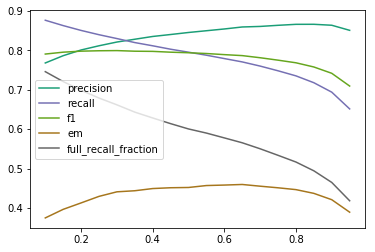

In [27]:
plt.figure(); metric_df.plot(colormap="Dark2");

In [28]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


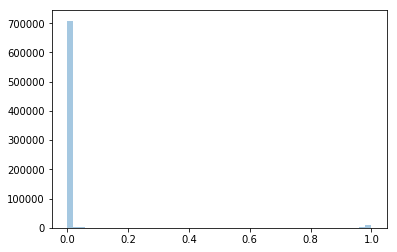

In [29]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy().flatten(),kde=False, hist=True, rug=False)

## Examining the predictions

In [30]:
threshold = 0.5

In [31]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()

In [32]:
# for individual question,paragraph pairs
wrong_prediction_indices = []
correct_prediction_indices = []
for i in range(len(dataset["supporting_fact"])):
    if( dataset["supporting_fact"][i] != pred_answer_labels[i]):
        wrong_prediction_indices.append(i)
    else:
        correct_prediction_indices.append(i)

In [33]:
len(wrong_prediction_indices)

73440

In [34]:
len(correct_prediction_indices)

0

In [35]:
def actually_print_q_p(q_p):
    print("Question: {}".format(q_p["question"]))
    print("=============================================")
    for i, s in enumerate(q_p["sequence"]):
        print("sentence {}: {}".format(i,s))
    print("=============================================")
    print("True labels:{}".format(q_p["true_label"]))
    print("=============================================")
    print("Predicted labels:{}".format(q_p["predicted_label"]))

def print_q_p_pair(index, dataset, pred_answer_labels):
    token_ids = dataset["sequence"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    q_p = {"question":" ".join(words).split("[SEP]")[0], 
            "sequence":" ".join(words).split("[SEP]")[1].split("."),
            "true_label":true_label,
            "predicted_label": pred_answer_labels[index]
           } 
    actually_print_q_p(q_p)
    
def get_q_p(index, dataset, pred_answer_labels):
    token_ids = dataset["sequence"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    q_p = {
            "sequence":" ".join(words),
            "true_label":true_label,
            "predicted_label": pred_answer_labels[index]
           } 
    return q_p

In [36]:
get_q_p(wrong_prediction_indices[2], dataset, pred_answer_labels)

{'sequence': '[CLS] were scott derrick ##son and ed wood of the same nationality ? [SEP] woods ##on is a census - designated place ( cdp ) in pu ##las ##ki county , arkansas , in the united states . its population was 403 at the 2010 census . it is part of the little rock – north little rock – conway metropolitan statistical area . woods ##on and its accompanying woods ##on lake and wood hollow are the namesake for ed wood sr . , a prominent plantation owner , trader , and businessman at the turn of the 20th century . woods ##on is adjacent to the wood plantation , the largest of the plantations own by ed wood sr . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]